In [1]:
import os, sys
import numpy as np
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## Setup

In [3]:
torch.manual_seed(12345)
k = 10000
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids
hydrophobicity = {'G': 0, 'A': 41, 'L':97, 'M': 74, 'F':100, 'W':97, 'K':-23, 'Q':-10, 'E':-31, 'S':-5, 'P':-46, 'V':76, 'I':99, 'C':49, 'Y':63, 'H':8, 'R':-14, 'N':-28, 'D':-55, 'T':13}
NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*13 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
aa_dict = dict(zip(aa_list, pvals))

## Dataset & Sampling

In [4]:
def construct_dataset():
    with open(aptamer_dataset_file, 'r') as f:
        aptamer_data = json.load(f)
    ds = []
    for aptamer in aptamer_data:
        peptides = aptamer_data[aptamer]
        for peptide in peptides:
            ds.append((aptamer, peptide))
    ds = list(set(ds)) #removed duplicates
    return ds

# Sample x from P_X (assume apatamers follow uniform)
def get_x():
    x_idx = np.random.randint(0, 4, 40)
    x = ""
    for i in x_idx:
        x += na_list[i]
    return x

# Sample y from P_y (assume peptides follow NNK)
def get_y():
    y_idx = np.random.choice(20, 7, p=pvals)
    y = "M"
    for i in y_idx:
        y += aa_list[i]
    return y

# S'(train/test) contains S_train/S_test with double the size of S_train/S_test
def get_S_prime(kind="train"):
    if kind == "train":
        dset = S_train
    else:
        dset = S_test
    k = len(dset)
    S_prime_dict = dict.fromkeys(dset, 0) #indicator 0 means in S
    for _ in range(k):
        pair = (get_x(), get_y())
        S_prime_dict[pair] = 1 #indicator 1 means not in S
    S_prime = [[k,int(v)] for k,v in S_prime_dict.items()] 
    np.random.shuffle(S_prime)
    return S_prime

# S new contains unseen new examples
def get_S_new(k):
    S_new = []
    for i in range(k):
        pair = (get_x(), get_y())
        S_new.append(pair)
    np.random.shuffle(S_new)
    return S_new
    
# Returns pmf of an aptamer
def get_x_pmf():
    return 0.25**40

# Returns pmf of a peptide
def get_y_pmf(y):
    pmf = 1
    for char in y[1:]: #skips first char "M"
        pmf *= aa_dict[char]
    return pmf    

In [5]:
aptamer_dataset_file = "../data/aptamer_dataset.json"
S = construct_dataset()
n = len(S)
m = int(0.8*n) #length of S_train
S_train = S[:m]
S_test = S[m:]
S_prime_train = get_S_prime("train") #use for sgd 
S_prime_test = get_S_prime("test") #use for sgd 
S_new = get_S_new(10*n) #use for eval
train_ds = np.hstack((S_train, S_prime_train[:len(S_prime_train)//2]))

## NN Model

In [8]:
class ConvNetSimple(nn.Module):
    def __init__(self):
        super(Conv1dModelSimple, self).__init__()
        self.cnn_apt_1 = nn.Conv1d(40, 100, 3) 
        self.cnn_apt_2 = nn.Conv1d(100, 50, 1)
        
        self.cnn_pep_1 = nn.Conv1d(8, 50, 3)
        self.cnn_pep_2 = nn.Conv1d(50, 25, 1)
        self.cnn_pep_3 = nn.Conv1d(25, 10, 1)

        
        self.relu = nn.ReLU()
        self.name = "ConvNetSimple"
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, self.cnn_apt_2, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu, self.cnn_pep_2, self.relu)
        
        self.fc1 = nn.Linear(275, 1)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        apt = self.relu(apt)
        pep = self.cnn_pep(pep)
        pep = self.relu(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [9]:
class LinearConv1d(nn.Module):
    def __init__(self):
        super(LinearConv1dModel, self).__init__()
        self.cnn_apt_1 = nn.Conv1d(40, 100, 3) 
        self.cnn_pep_1 = nn.Conv1d(8, 50, 3)

        self.relu = nn.ReLU()
        self.name = "LinearConv1d"
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(550, 1)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [10]:
class LinearNet(nn.Module):
    def __init__(self):
        super(TrueLinearNet, self).__init__()
        self.lin_apt_1 = nn.Linear(160, 100) 
        self.lin_apt_2 = nn.Linear(100, 50)
        self.lin_apt_3 = nn.Linear(50, 10)
        
        self.lin_pep_1 = nn.Linear(160, 50)
        self.lin_pep_2 = nn.Linear(50, 10)

        self.relu = nn.ReLU()
        
        self.name = "LinearNet"
        
        self.lin_apt = nn.Sequential(self.lin_apt_1, self.lin_apt_2, self.lin_apt_3)
        self.lin_pep = nn.Sequential(self.lin_pep_1, self.lin_pep_2)
        
        self.fc1 = nn.Linear(20, 1)
        
    def forward(self, apt, pep):
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        apt = self.lin_apt(apt)
        pep = self.lin_pep(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [11]:
# This model is too complex for our input sequence size
class ConvNetComplex(nn.Module):
    def __init__(self):
        super(Conv1dModel, self).__init__()
        self.cnn_apt_1 = nn.Conv1d(40, 500, 3) 
        self.cnn_apt_2 = nn.Conv1d(500, 300, 1)
        self.cnn_apt_3 = nn.Conv1d(300, 150, 1)
        self.cnn_apt_4 = nn.Conv1d(150, 75, 1)
        self.cnn_apt_5 = nn.Conv1d(25, 10, 1)
        
        self.cnn_pep_1 = nn.Conv1d(8, 250, 3)
        self.cnn_pep_2 = nn.Conv1d(250, 500, 1)
        self.cnn_pep_3 = nn.Conv1d(500, 250, 1)
        self.cnn_pep_4 = nn.Conv1d(250, 100, 1)
        self.cnn_pep_5 = nn.Conv1d(100, 10, 1)
        
        self.relu = nn.ReLU()
        self.name = "ConvNetComplex"
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, self.cnn_apt_2, self.maxpool, self.relu, self.cnn_apt_3, self.maxpool, self.relu, self.cnn_apt_4, self.maxpool, self.relu, self.cnn_apt_5, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu, self.cnn_pep_2, self.maxpool, self.relu, self.cnn_pep_3, self.maxpool, self.relu, self.cnn_pep_4, self.maxpool, self.relu, self.cnn_pep_5, self.relu)
        
        self.fc1 = nn.Linear(180, 1)
        
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        apt = self.relu(apt)
        pep = self.cnn_pep(pep)
        pep = self.relu(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

## Helper methods

In [12]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide'):
    if seq_type == 'peptide':
        letters = aa_list
    else:
        letters = na_list
    one_hot = np.zeros((len(sequence), len(letters)))
    for i in range(len(sequence)):
        char = sequence[i]
        for _ in range(len(letters)):
            idx = letters.index(char)
            one_hot[i][idx] = 1
    return one_hot

# Convert a pair to one-hot tensor
def convert(apt, pep): 
    apt = one_hot(apt, seq_type='aptamer') #(40, 4)
    pep = one_hot(pep, seq_type='peptide') #(8, 20)
    apt = torch.FloatTensor(np.reshape(apt, (1, apt.shape[0], apt.shape[1]))).cuda() #(1, 40, 4)
    pep = torch.FloatTensor(np.reshape(pep, (1, pep.shape[0], pep.shape[1]))).cuda() #(1, 8, 20)
    return apt, pep

# Getting the output of the model for a pair (aptamer, peptide)
def update(x, y):
    x.requires_grad=True
    y.requires_grad=True
    x = x.cuda()
    y = y.cuda()
    out = model(x, y)
    return out

# Generates the samples used to calculate loss
def loss_samples(k, ds='train'): # S_train/S_test
    if ds == 'train':
        dset = S_train
    else:
        dset = S_test
    pairs = []
    for (apt, pep) in dset[:k]:
        x, y = convert(apt, pep)
        pairs.append((x, y))
    return pairs

# Generates the samples used to calculate loss from S_prime_train/S_prime_test
def prime_loss_samples(k, ds='train'): # S_prime_train/S_prime_test
    if ds == "train":
        dset = S_prime_train[len(S_prime_train)//2:]    
    else:
        dset = S_prime_test[len(S_prime_test)//2:]
    pairs = []
    for (apt, pep), ind in dset[:k]:
        pmf = get_y_pmf(pep)
        x, y = convert(apt, pep)
        pairs.append((x, y, ind, pmf))
    return pairs

# First term of the loss
def get_log_out(dataset='train'):
    outs = []
    if dataset == 'train':
        dset = train_loss_samples
    else:
        dset = test_loss_samples
    for (apt, pep) in dset:
        out = update(apt, pep)
        outs.append(torch.log(out).cpu().detach().numpy().flatten()[0])
    return np.average(outs)

# Second term of loss
def get_out_prime(ds="train"):
    outs = []
    if ds == "train":
        dset = prime_train_loss_samples
        leng = m
    else:
        dset = prime_test_loss_samples
        leng = n-m
    for (apt, pep, ind, pmf) in dset:
        x = apt.cuda()
        y = pep.cuda()
        out = model(x, y)
        if ind == 0:
            factor = (2*leng*get_x_pmf()*pmf)/(1+leng*get_x_pmf()*pmf)
        else:
            factor = 2
        out_is = out.cpu().detach().numpy().flatten()[0] * factor
        outs.append(out_is)
    return np.average(outs)

## Plotting functions

def plot_loss(train_loss, test_loss, i, j, lamb, gamma):
    plt.plot(train_loss, 'b', label='Train loss')
    plt.plot(test_loss, 'y', label='Test loss')
    plt.ylabel("Loss")
    plt.xlabel("Number of iterations")
    plt.title('Loss after ' +  str(i) + " iterations, " + str(j) + " epochs, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()

def plot_recall(train_recall, test_recall, new_recall, i, j, lamb, gamma):
    plt.plot(train_recall, 'b', label='Train recall')
    plt.plot(test_recall, 'y', label='Test recall')
    plt.plot(new_recall, 'r', label='New recall')
    plt.ylabel("Recall (%)")
    plt.xlabel("Number of iterations")
    plt.title('Recall after ' + str(i) + " iterations, " + str(j) + " epochs, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()

def plot_ecdf_test(test_score, i, j, lamb, gamma):
    test_idx = np.argsort(test_score)
    test_id = test_idx > 10000
    test = np.sort(test_score)
    test_c = ""
    for m in test_id:
        if m:
            test_c += "y"
        else:
            test_c += "g"
    n = test_score.size
    y = np.arange(1, n+1) / n
    plt.scatter(y, test, c=test_c, label='Test CDF')
    plt.xlabel("CDF")
    plt.ylabel("Most recent 10,000 samples")
    plt.title('CDF after ' + str(i) + " iterations, " + str(j) + " epochs, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()

def plot_ecdf_train(train_score, i, j, lamb, gamma):
    #train_score consisits of [10000 scores generated] + [1000 scores from training set]
    train_idx = np.argsort(train_score)
    train_id = train_idx > 10000
    train = np.sort(train_score)
    train_c = "" #colors
    for l in train_id:
        if l:
            train_c += "r"
        else:
            train_c += "b"
    n = train_score.size
    y = np.arange(1, n+1) / n
    plt.scatter(y, train, c=train_c, label='Train CDF')
    plt.xlabel("CDF")
    plt.ylabel("Most recent 10,000 samples")
    plt.title('CDF after ' + str(i) + " iterations, " + str(j) + " epochs, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()

def histogram(eval_scores, train_scores, test_scores):
    fig, ax = plt.subplots()
    plt.xlim(0, 1.1)
    sns.distplot(eval_scores , color="skyblue", label='New: not in dataset', ax=ax)
    sns.distplot(train_scores , color="gold", label='Train: in dataset', ax=ax)
    sns.distplot(test_scores, color='red', label='Test: in the dataset', ax=ax)
    ax.set_title("Distribution of Scores")
    ax.figure.set_size_inches(7, 4)
    ax.legend()
    plt.show()

In [ ]:
train_loss_samples = loss_samples(k, 'train')
test_loss_samples = loss_samples(k, 'test')
prime_train_loss_samples = prime_loss_samples(k, 'train')
prime_test_loss_samples = prime_loss_samples(k, 'test')

## SGD

In [13]:
'''
lamb = hyperparameter
gamma = step size
run_from_checkpoint = path to a checkpointed model
save_checkpoings = file name
'''
def sgd(epochs=[1, 2, 3], 
        lamb=[10, 10, 10], 
        gamma=[1e-3, 1e-4, 1e-5], 
        run_from_checkpoint=None, 
        save_checkpoints=None): 
    
    if run_from_checkpoint is not None:
        checkpointed_model = run_from_checkpoint
        checkpoint = torch.load(checkpointed_model)
        
        optim = SGD(model.parameters(), lr=gamma[0])

        model.load_state_dict(checkpoint['model_state_dict'])
        optim.load_state_dict(checkpoint['optimizer_state_dict'])
        reloaded_epoch = checkpoint['epoch']
        print("Reloading model: " + str(model.name) + " at epoch: " + str(reloaded_epoch))
        epoch = reloaded_epoch
    else:
        model.apply(weights_init)
    
    model.to(device)
    
    train_losses = []
    test_losses = []
    total_epochs = 0
    for i in range(len(epochs)):
        g = gamma[i]
        l = lamb[i]
        eps = epochs[i]
        epoch = 0
        optim = SGD(model.parameters(), lr=g)
        while epoch < eps:
            train_recalls = []
            train_recall_outputs = [] 
            test_recalls = []
            test_recall_outputs = []
            new_outputs = []
            new_recalls = []
            train_correct = 0
            test_correct = 0
            new_correct = 0
            print("Training Epoch: ", total_epochs)
            for i, (aptamer, peptide, (apt_prime, pep_prime), indicator) in enumerate(tqdm.tqdm(train_ds)):
                if i == 0:
                    continue
                model.train()
                optim.zero_grad() 
                x, y = convert(aptamer, peptide) #sample x,y from S_train
                out = update(x, y) #get S_train output/score
                log_out = torch.log(out) 

                train_score = out.cpu().detach().numpy().flatten()[0] 
                if train_score > 0.6:
                    train_correct += 1 
                train_recall_outputs.append(train_score) 

                optim.zero_grad() 
                y_pmf = get_y_pmf(pep_prime)
                x_prime, y_prime = convert(apt_prime, pep_prime) #sample x', y' from S_prime_train
                out_prime = update(x_prime, y_prime) #get score from S_prime_train
                if indicator == 0:
                    factor = (2*m*get_x_pmf()*y_pmf)/(1+m*get_x_pmf()*y_pmf)
                else:
                    factor = 2
                out_prime = out_prime*factor #adjust for IS
                #print("Obj first part: ", out_prime.cpu().detach().numpy().flatten()[0]*lamb*indicator)
                #print("Obj second part: ", log_out.cpu().detach().numpy().flatten()[0])
                # Retain graph retains the graph for further operations
                (l*indicator*out_prime - log_out).backward(retain_graph=True) 
                optim.step()

                with torch.no_grad():
                    model.eval()

                x_test, y_test = convert(S_test[i%(n-m)][0], S_test[i%(n-m)][1]) #sample x,y from test set
                test_score = model(x_test, y_test).cpu().detach().numpy().flatten()[0]
                test_recall_outputs.append(test_score) 
                if test_score > 0.6:
                    test_correct += 1 

                #generate 10 unseen examples from S_new as compared 1 example from S_train/S_test for cdfs
                for x, y in S_new[10*i:10*(i+1)]:
                    x_new, y_new = convert(x, y) #generate unseen x'' and y'' from S_new
                    new_score = model(x_new, y_new).cpu().detach().numpy().flatten()[0] #get unknown score
                    new_outputs.append(new_score)
                    if new_score < 0.3:
                        new_correct += 1

                if i % 10000 == 0:
                    train_loss = l*get_out_prime("train") - get_log_out('train') #training loss
                    #print("Train loss first part: ", lamb*get_out_prime("train"))
                    #print("Train loss second part: ", get_log_out('train'))
                    test_loss = (m/(n-m))*l*get_out_prime("test") - get_log_out('test') #test loss
                    #print("Test loss first part: ", lamb*get_out_prime("test"))
                    #print("Test loss second part: ", get_log_out('test'))
                    train_losses.append(train_loss)
                    test_losses.append(test_loss)

                    train_recall = 100*train_correct/(total_epochs*len(train_ds) + i) #training recall
                    train_recalls.append(train_recall) 
                    test_recall = 100*test_correct/(total_epochs*len(train_ds) + i) #test recall
                    test_recalls.append(test_recall)
                    new_recall = 100*new_correct/(i*10) #generated dataset recall
                    new_recalls.append(new_recall)
                    if i > 1000:
                        train_score = np.asarray(new_outputs[-10000:] + train_recall_outputs[-1000:]) 
                        test_score = np.asarray(new_outputs[-10000:] + test_recall_outputs[-1000:])
                    else:
                        train_score = np.asarray(new_outputs + train_recall_outputs) #combine train and unknown scores
                        test_score = np.asarray(new_outputs + test_recall_outputs) #combibne test and unknown scores


                if i % 100000 == 0:
                    plot_recall(train_recalls, test_recalls, new_recalls, i, total_epochs, l, g)
                    plot_loss(train_losses, test_losses, i, total_epochs, l, g)
                    plot_ecdf_train(train_score, i, total_epochs, l, g)
                    plot_ecdf_test(test_score, i, total_epochs, l, g)
                    histogram(new_outputs[-1000:], train_recall_outputs[-1000:], test_recall_outputs[-1000:])
                    print("New score: ", np.average(new_outputs[-50:]))
                    print("Train score: ", np.average(train_score[-50:]))
                    print("Test score: ", np.average(test_score[-50:]))
        
            # Save after every epoch
            total_epochs += 1
            epoch += 1
            if save_checkpoints is not None:
                print("Saving to: ", save_checkpoints)
                checkpoint_name = save_checkpoints
                torch.save({'epoch': epoch,'model_state_dict': model.state_dict(), 'optimizer_state_dict': optim.state_dict()}, checkpoint_name)


## Hyperparameter tuning

In [14]:
# Hyperparameter search
gamma = [1e-2, 1e-3, 1e-4, 1e-5]
lamb = [10, 10, 10, 10]
EPOCHS = [2, 3, 3, 3]

  0%|          | 2/473047 [00:00<11:08:09, 11.80it/s]

('Training Epoch: ', 0)


 21%|██        | 99999/473047 [47:30<2:57:09, 35.10it/s]  

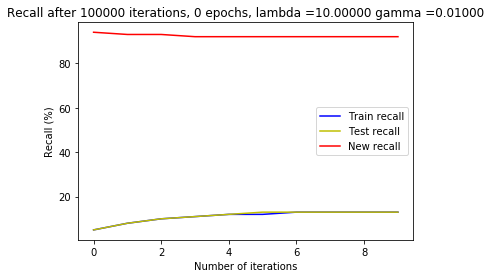

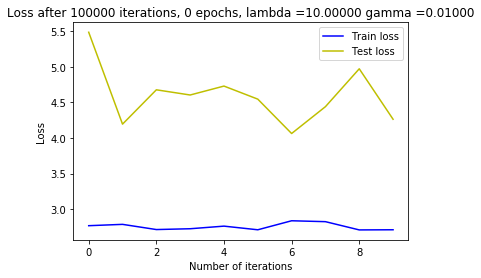

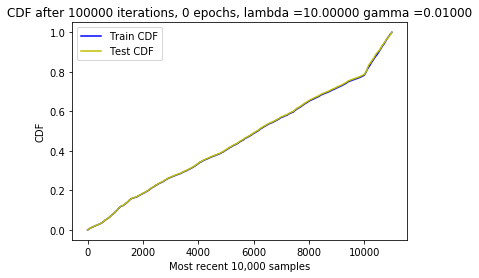

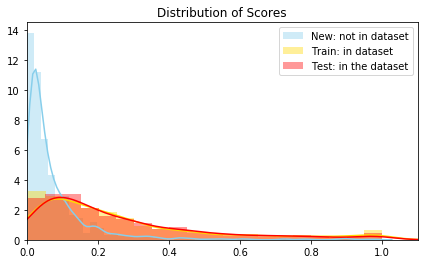

 21%|██        | 100005/473047 [47:34<241:06:05,  2.33s/it]

('New score: ', 0.10321129)
('Train score: ', 0.20698318)
('Test score: ', 0.23707068)


 42%|████▏     | 199998/473047 [1:34:50<2:09:34, 35.12it/s]  

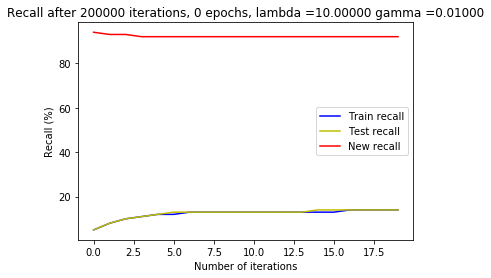

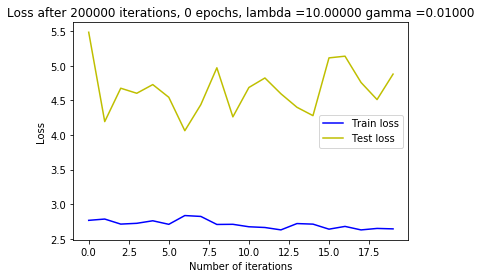

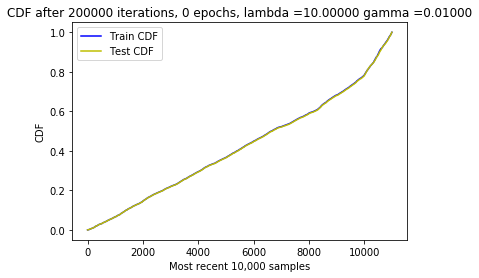

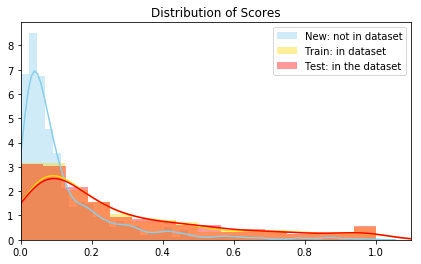

 42%|████▏     | 200006/473047 [1:34:56<117:02:19,  1.54s/it]

('New score: ', 0.15770705)
('Train score: ', 0.35000002)
('Test score: ', 0.37303293)


 63%|██████▎   | 299998/473047 [2:23:10<1:27:43, 32.88it/s]  

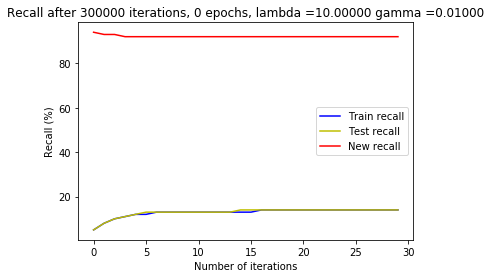

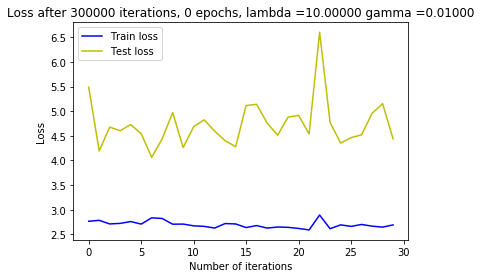

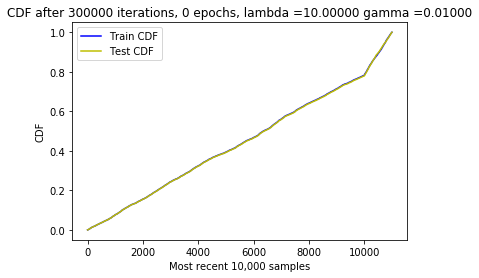

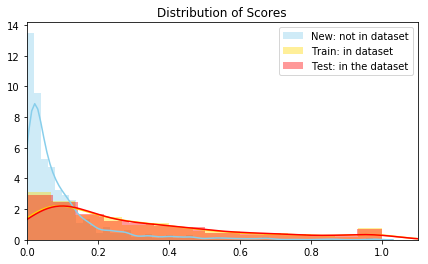

 63%|██████▎   | 300005/473047 [2:23:19<74:31:23,  1.55s/it] 

('New score: ', 0.071242996)
('Train score: ', 0.24708606)
('Test score: ', 0.29862687)


 85%|████████▍ | 400000/473047 [3:13:00<34:35, 35.19it/s]    

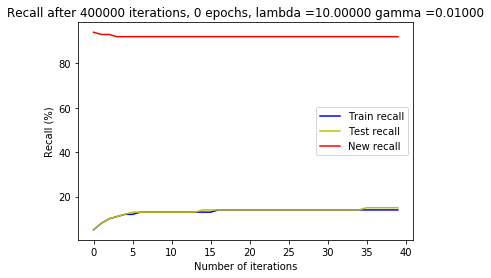

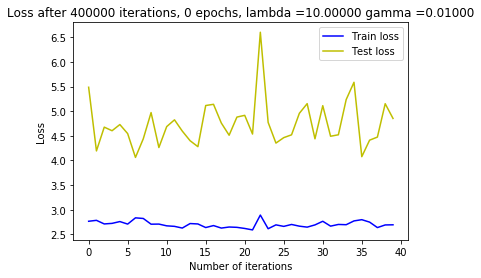

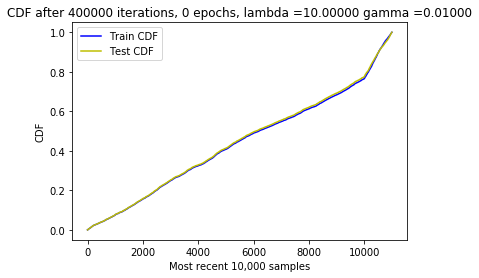

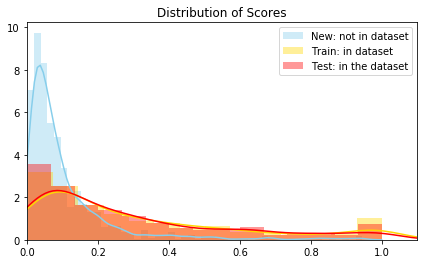

 85%|████████▍ | 400006/473047 [3:13:03<93:11:54,  4.59s/it] 

('New score: ', 0.08354283)
('Train score: ', 0.27386618)
('Test score: ', 0.31738517)


100%|██████████| 473047/473047 [3:46:57<00:00, 34.74it/s]   


('Saving to: ', 'model_checkpoints/Conv1dModelSimple/04152020.pth')


 21%|██        | 99999/473047 [49:20<3:01:10, 34.32it/s]  

('Training Epoch: ', 1)


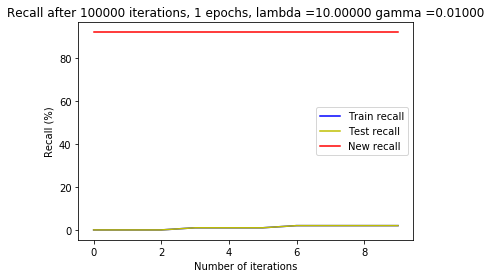

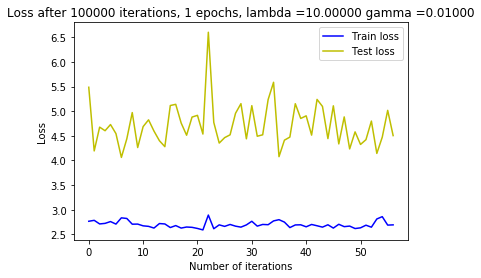

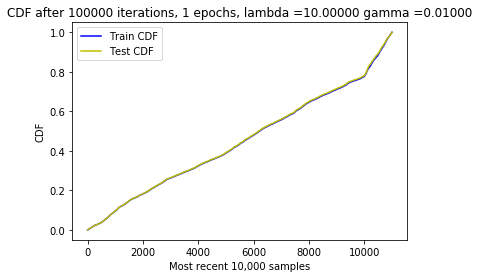

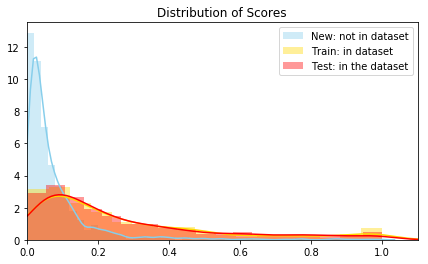

 21%|██        | 100005/473047 [49:23<250:25:24,  2.42s/it]

('New score: ', 0.085325)
('Train score: ', 0.25775334)
('Test score: ', 0.2703655)


 73%|███████▎  | 345673/473047 [2:47:10<1:01:02, 34.78it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 78%|███████▊  | 368318/473047 [2:57:14<42:29, 41.08it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 82%|████████▏ | 389760/473047 [3:07:16<39:58, 34.73it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config va

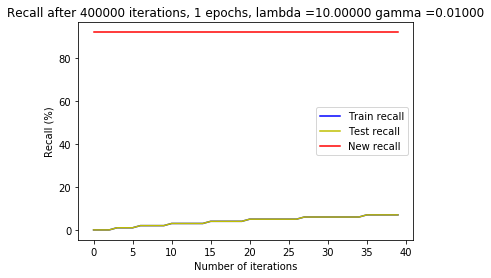

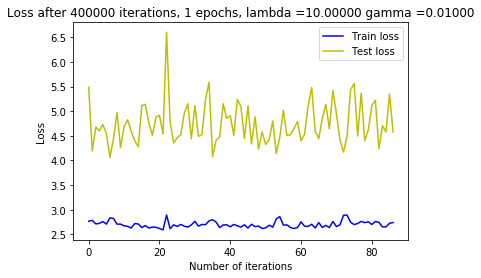

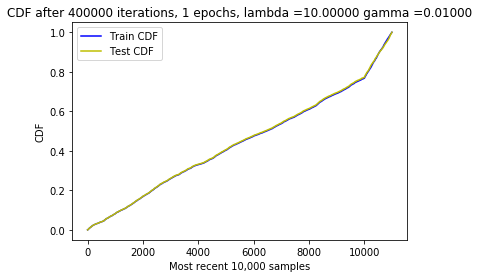

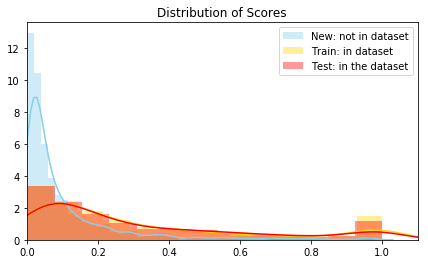

 85%|████████▍ | 400006/473047 [3:12:10<23:36:06,  1.16s/it]

('New score: ', 0.07640325)
('Train score: ', 0.28338984)
('Test score: ', 0.3270754)


 87%|████████▋ | 411066/473047 [3:17:53<24:42, 41.80it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 91%|█████████ | 429904/473047 [3:27:06<20:35, 34.92it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 95%|█████████▌| 450511/473047 [3:37:04<09:04, 41.40it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config va

('Training Epoch: ', 2)


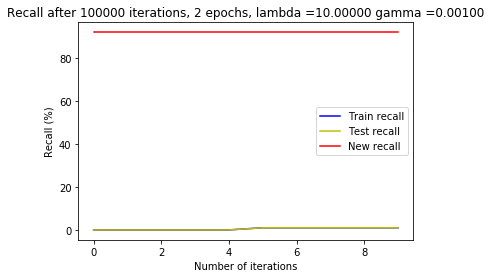

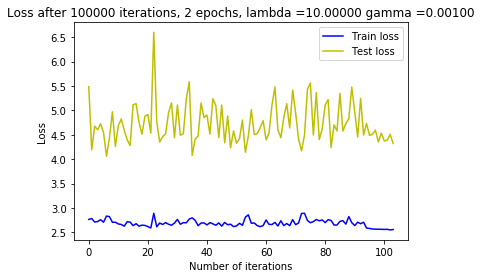

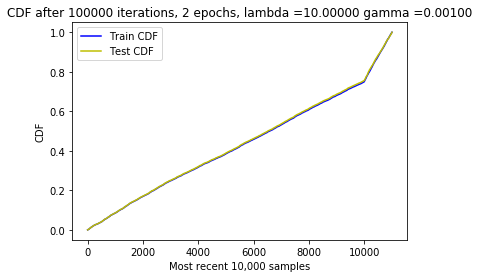

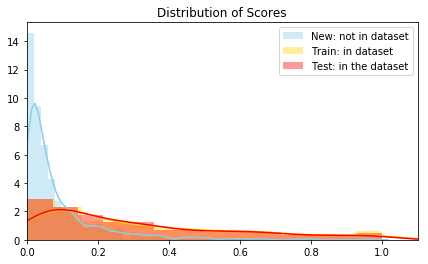

 21%|██        | 100006/473047 [47:37<164:56:42,  1.59s/it]

('New score: ', 0.1135283)
('Train score: ', 0.30280477)
('Test score: ', 0.33043846)


 22%|██▏       | 104958/473047 [49:50<2:47:47, 36.56it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 40%|███▉      | 189041/473047 [1:29:44<2:16:55, 34.57it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 42%|████▏     | 199999/473047 [1:34:50<1:49:13, 41.66it/s]

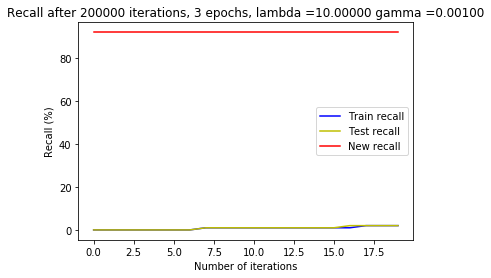

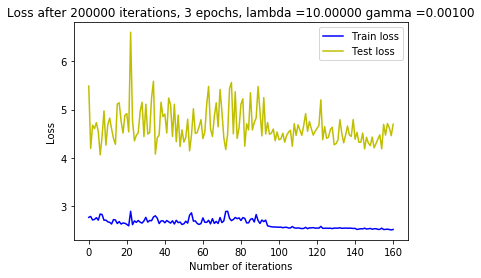

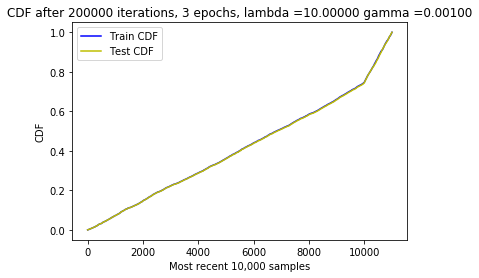

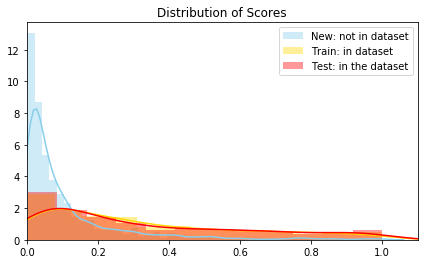

 42%|████▏     | 200005/473047 [1:34:57<174:35:22,  2.30s/it]

('New score: ', 0.15371077)
('Train score: ', 0.38046074)
('Test score: ', 0.33381534)


 45%|████▍     | 212019/473047 [1:40:08<1:44:17, 41.71it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 49%|████▉     | 233903/473047 [1:49:52<2:02:49, 32.45it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 54%|█████▎    | 253354/473047 [1:59:33<1:44:49, 34.93it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config

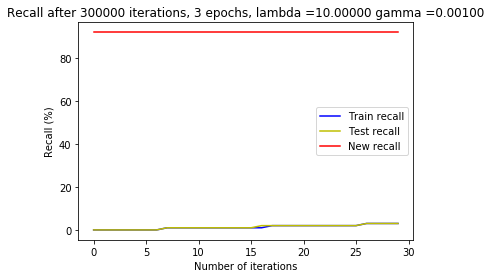

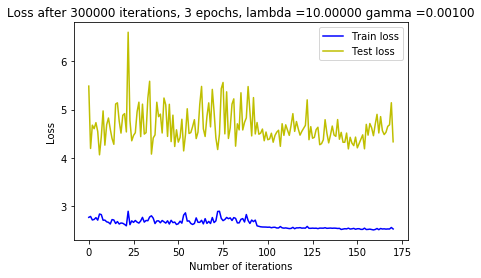

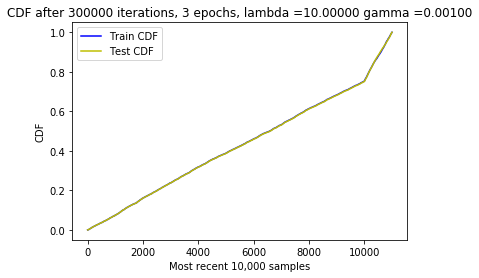

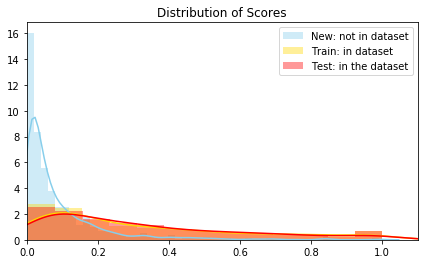

 63%|██████▎   | 300005/473047 [2:23:08<75:06:33,  1.56s/it] 

('New score: ', 0.07866902)
('Train score: ', 0.3096879)
('Test score: ', 0.34106496)


 66%|██████▌   | 311972/473047 [2:28:59<1:17:53, 34.46it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 70%|███████   | 332187/473047 [2:39:06<1:07:04, 35.00it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 74%|███████▍  | 350881/473047 [2:48:10<49:26, 41.18it/s]    IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config

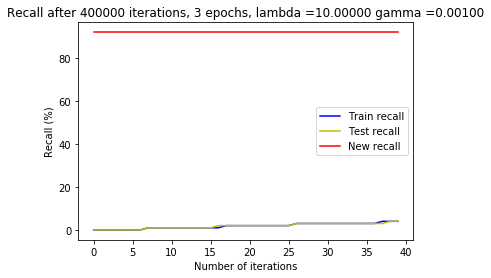

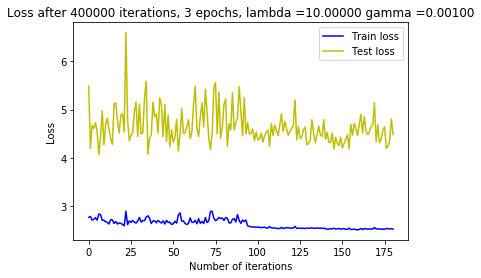

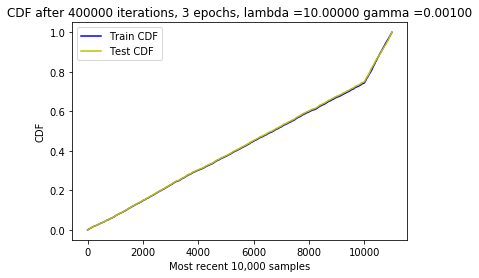

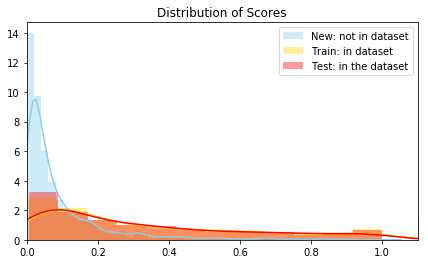

 85%|████████▍ | 400005/473047 [3:12:54<94:36:37,  4.66s/it] 

('New score: ', 0.070479624)
('Train score: ', 0.3360424)
('Test score: ', 0.33959615)


100%|██████████| 473047/473047 [3:46:52<00:00, 34.75it/s]   


('Saving to: ', 'model_checkpoints/Conv1dModelSimple/04152020.pth')


 21%|██        | 99998/473047 [46:20<2:59:27, 34.64it/s]  

('Training Epoch: ', 4)


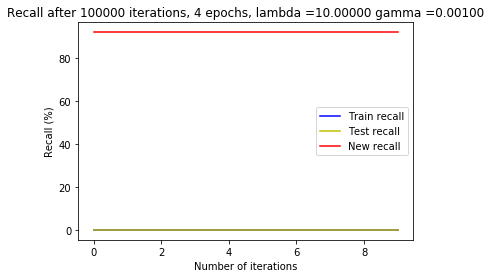

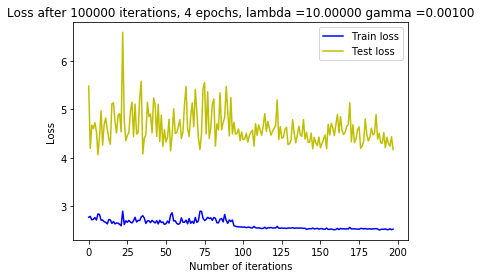

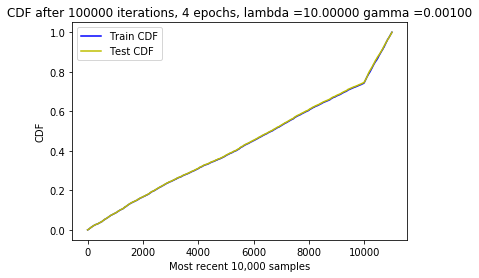

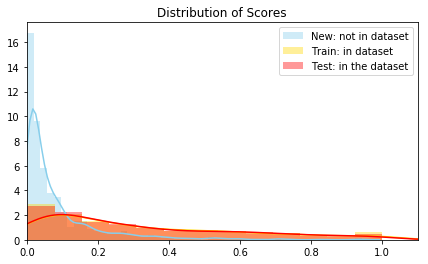

 21%|██        | 100005/473047 [46:32<172:58:00,  1.67s/it]

('New score: ', 0.12054035)
('Train score: ', 0.32309106)
('Test score: ', 0.31849003)


 42%|████▏     | 200000/473047 [1:37:20<2:12:39, 34.31it/s]  

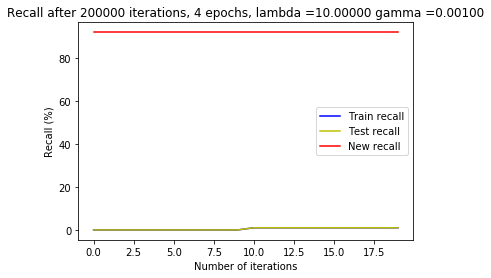

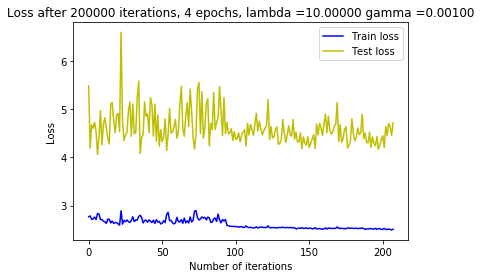

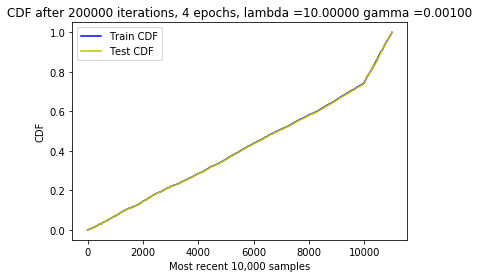

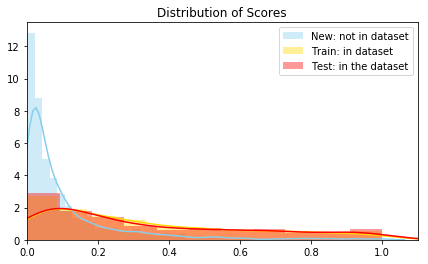

 42%|████▏     | 200005/473047 [1:37:30<378:04:43,  4.98s/it]

('New score: ', 0.15257925)
('Train score: ', 0.3868062)
('Test score: ', 0.33885953)


 63%|██████▎   | 299999/473047 [2:25:10<1:23:36, 34.50it/s]  

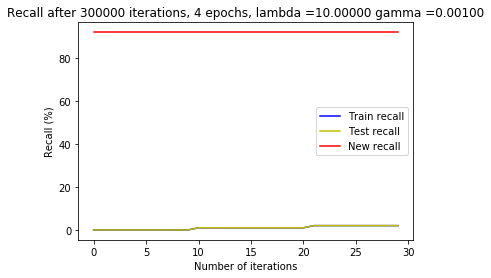

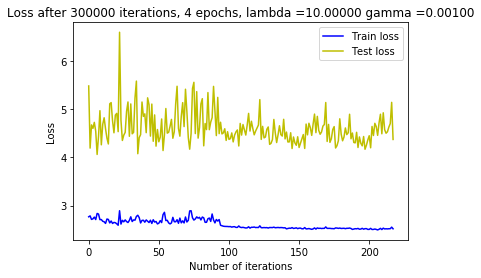

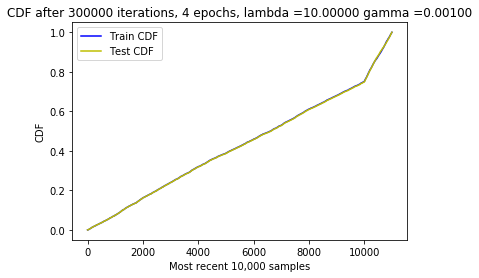

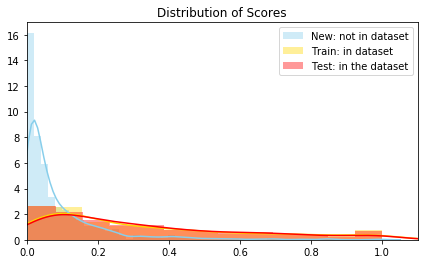

 63%|██████▎   | 300005/473047 [2:25:18<114:10:34,  2.38s/it]

('New score: ', 0.079597905)
('Train score: ', 0.31332958)
('Test score: ', 0.3498896)


 85%|████████▍ | 399997/473047 [3:16:30<35:23, 34.40it/s]    

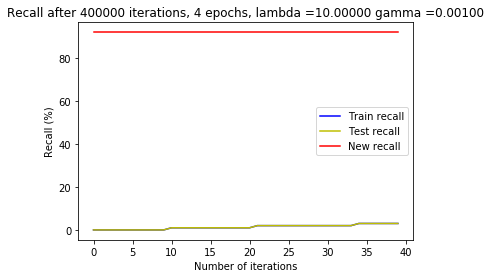

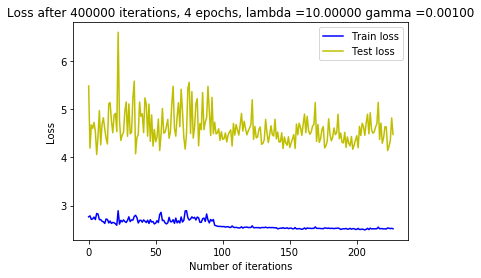

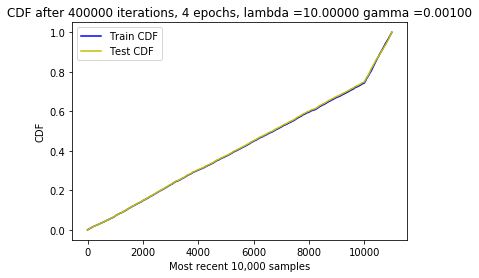

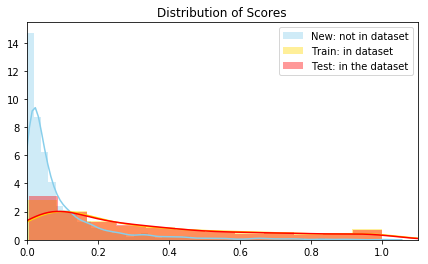

 85%|████████▍ | 400005/473047 [3:16:35<24:39:53,  1.22s/it]

('New score: ', 0.068564914)
('Train score: ', 0.3429619)
('Test score: ', 0.3438054)


100%|██████████| 473047/473047 [3:53:33<00:00, 33.76it/s]    


('Saving to: ', 'model_checkpoints/Conv1dModelSimple/04152020.pth')


 21%|██        | 100000/473047 [48:20<3:02:09, 34.13it/s] 

('Training Epoch: ', 5)


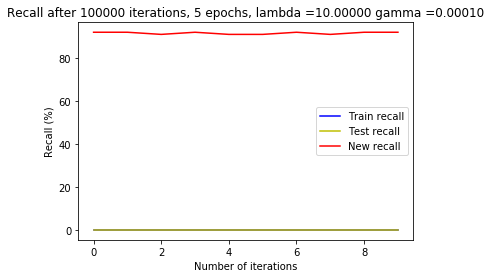

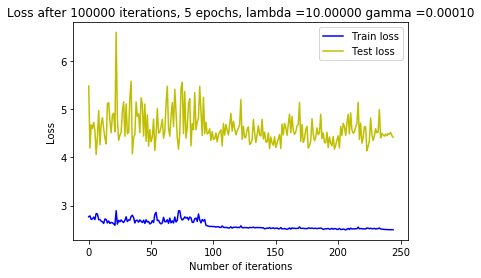

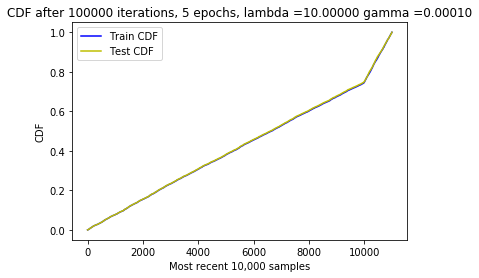

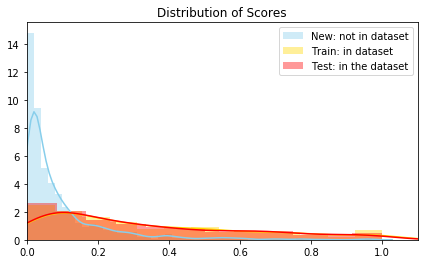

 21%|██        | 100005/473047 [48:27<488:29:02,  4.71s/it]

('New score: ', 0.1396473)
('Train score: ', 0.35524386)
('Test score: ', 0.35065755)


 42%|████▏     | 199997/473047 [1:37:00<2:11:15, 34.67it/s]  

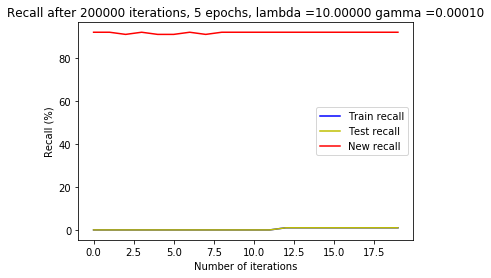

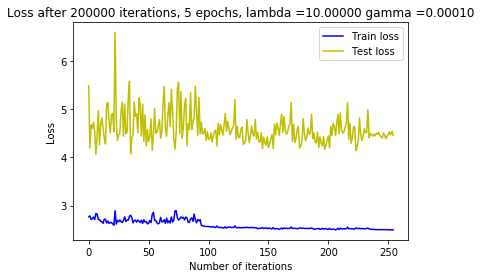

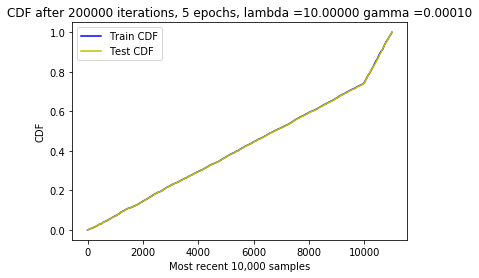

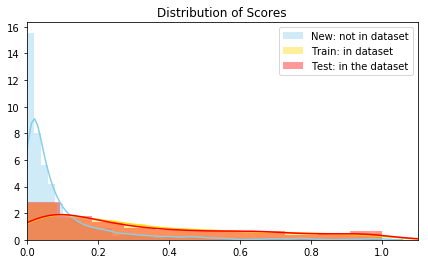

 42%|████▏     | 200006/473047 [1:37:03<90:13:48,  1.19s/it] 

('New score: ', 0.13952208)
('Train score: ', 0.36195382)
('Test score: ', 0.3130394)


 63%|██████▎   | 299998/473047 [2:25:00<1:24:44, 34.04it/s]  

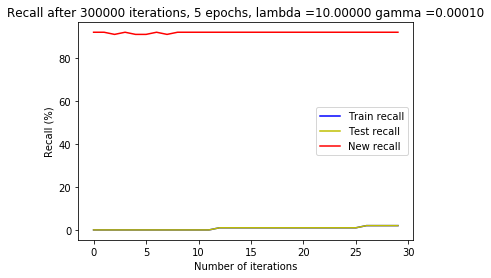

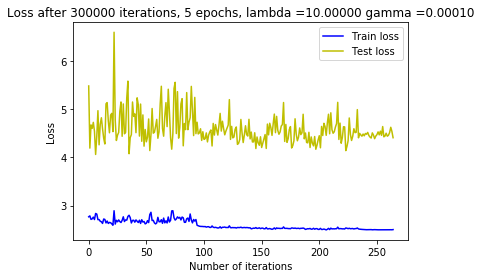

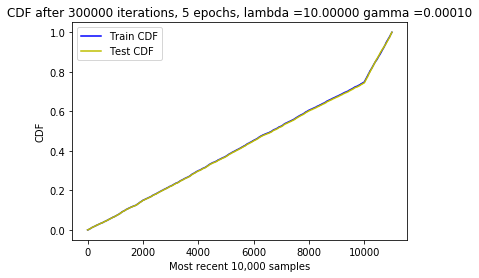

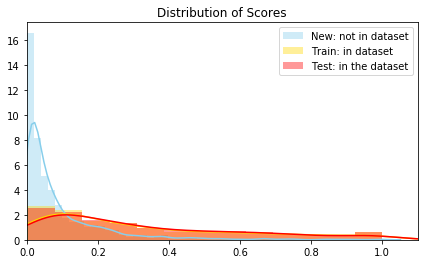

 63%|██████▎   | 300005/473047 [2:25:10<80:34:12,  1.68s/it] 

('New score: ', 0.08086089)
('Train score: ', 0.32496572)
('Test score: ', 0.36251137)


 85%|████████▍ | 399996/473047 [3:08:00<29:14, 41.64it/s]    

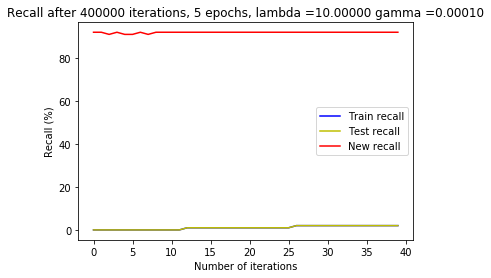

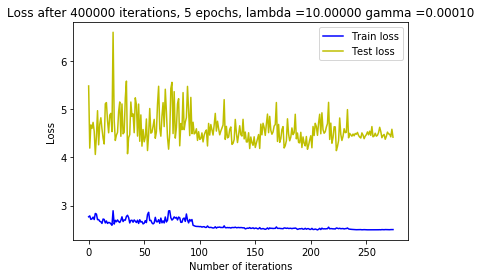

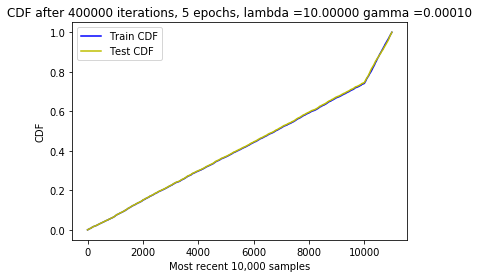

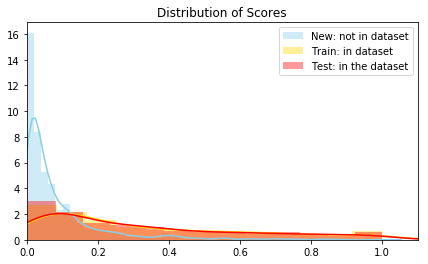

 85%|████████▍ | 400005/473047 [3:08:11<19:25:33,  1.04it/s]

('New score: ', 0.07026702)
('Train score: ', 0.32699123)
('Test score: ', 0.34002545)


100%|██████████| 473047/473047 [3:41:40<00:00, 35.57it/s]   


('Saving to: ', 'model_checkpoints/Conv1dModelSimple/04152020.pth')


  0%|          | 5/473047 [00:00<2:44:40, 47.88it/s]

('Training Epoch: ', 6)


 21%|██        | 100000/473047 [47:10<3:00:37, 34.42it/s] 

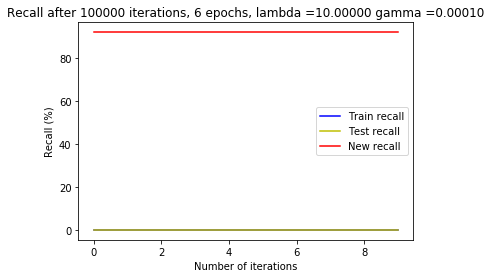

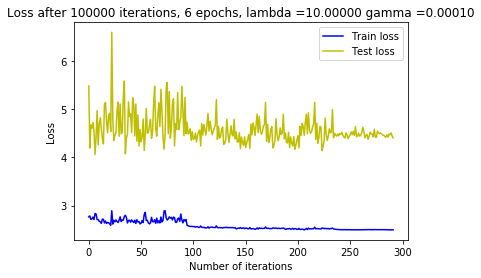

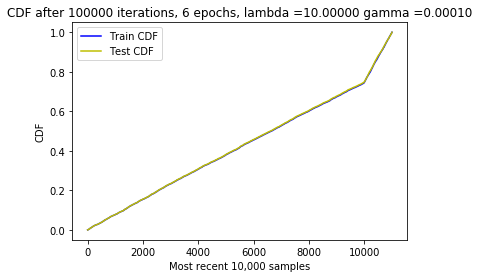

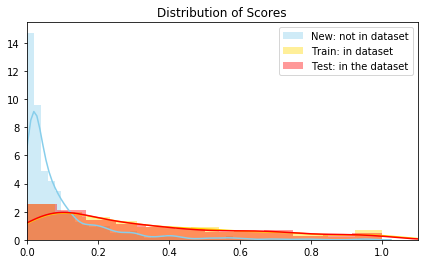

 21%|██        | 100005/473047 [47:21<478:45:54,  4.62s/it]

('New score: ', 0.13999444)
('Train score: ', 0.35417655)
('Test score: ', 0.35129714)


 42%|████▏     | 199997/473047 [1:31:40<2:11:20, 34.65it/s]  

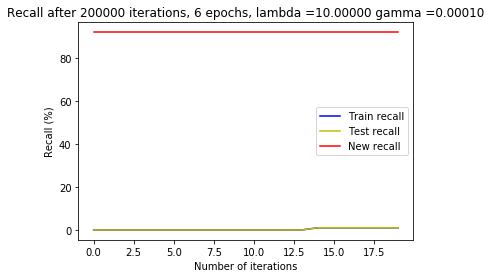

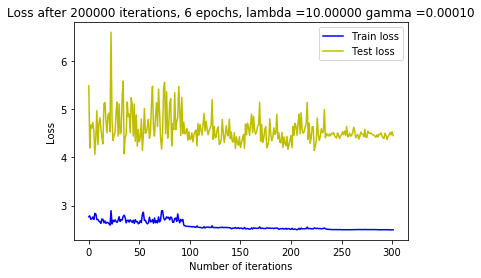

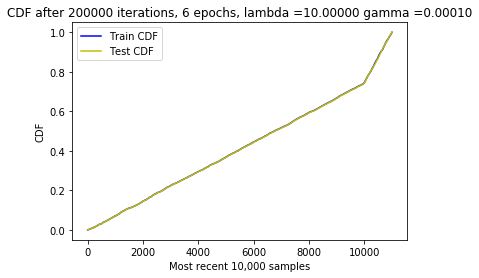

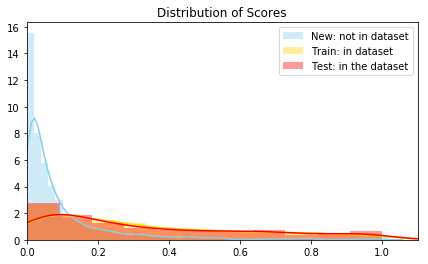

 42%|████▏     | 200005/473047 [1:31:43<89:04:03,  1.17s/it] 

('New score: ', 0.14084439)
('Train score: ', 0.36382523)
('Test score: ', 0.3136264)


 63%|██████▎   | 299997/473047 [2:20:50<1:24:15, 34.23it/s]  

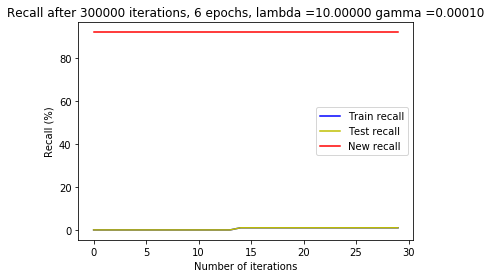

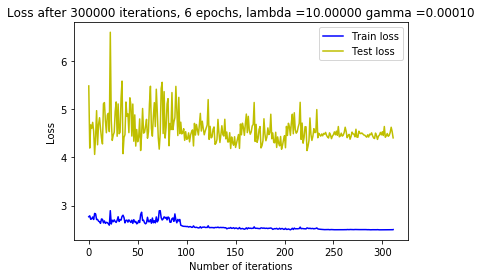

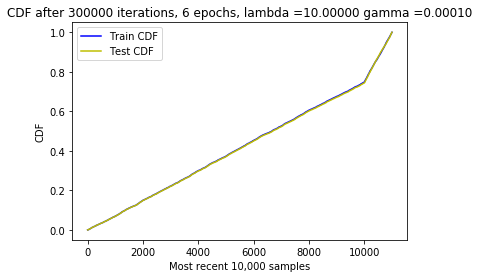

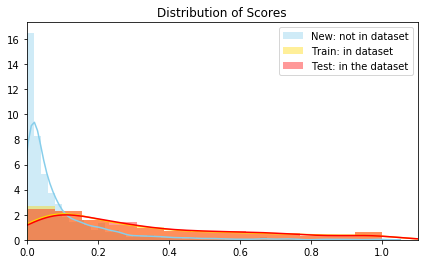

 63%|██████▎   | 300005/473047 [2:21:01<57:54:17,  1.20s/it]

('New score: ', 0.08106474)
('Train score: ', 0.32646695)
('Test score: ', 0.36422732)


 85%|████████▍ | 399998/473047 [3:09:30<41:04, 29.64it/s]    

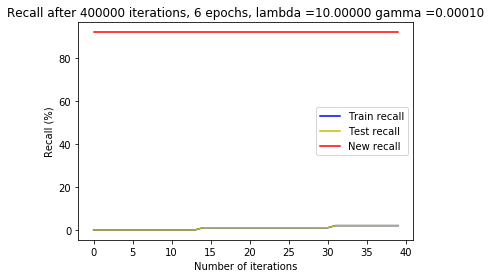

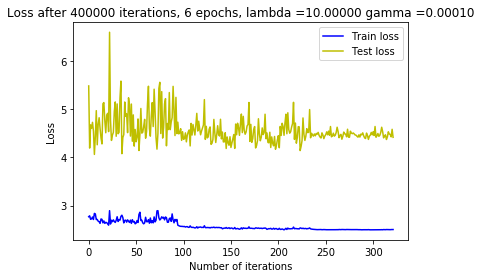

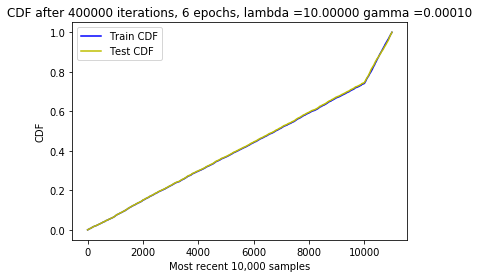

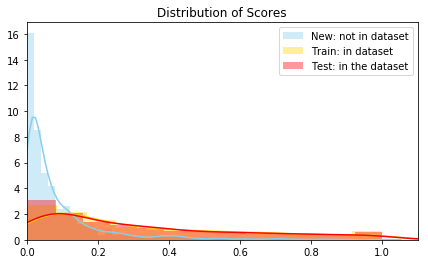

 85%|████████▍ | 400005/473047 [3:09:44<39:44:12,  1.96s/it]

('New score: ', 0.07036451)
('Train score: ', 0.32696345)
('Test score: ', 0.34069428)


100%|██████████| 473047/473047 [3:45:29<00:00, 34.96it/s]   


('Saving to: ', 'model_checkpoints/Conv1dModelSimple/04152020.pth')


 21%|██        | 99999/473047 [50:30<2:59:52, 34.56it/s]  

('Training Epoch: ', 7)


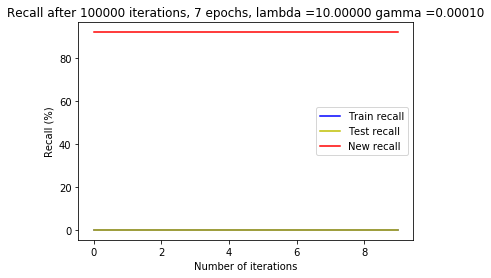

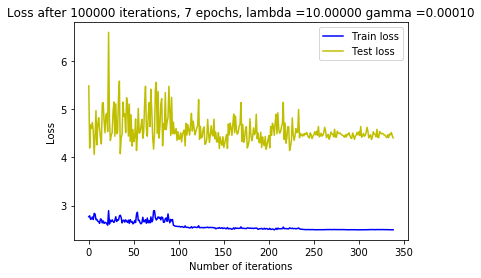

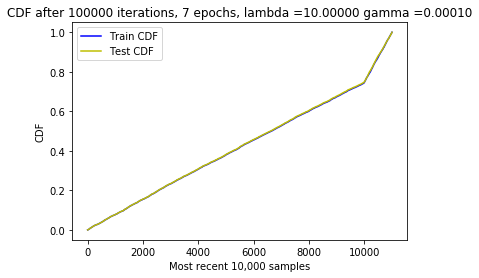

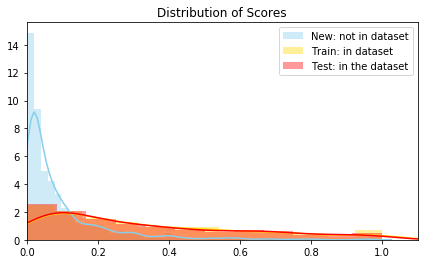

 21%|██        | 100005/473047 [50:37<247:36:14,  2.39s/it]

('New score: ', 0.14017785)
('Train score: ', 0.35514954)
('Test score: ', 0.35193458)


 42%|████▏     | 199996/473047 [1:38:00<1:38:04, 46.40it/s]  

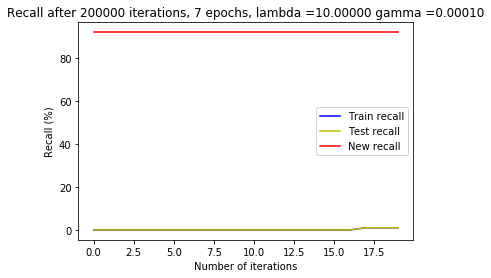

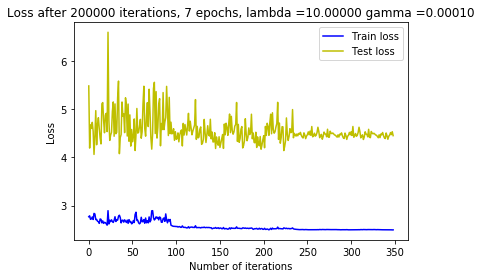

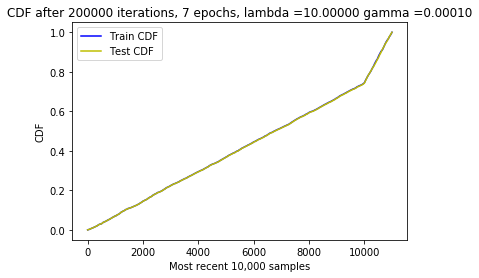

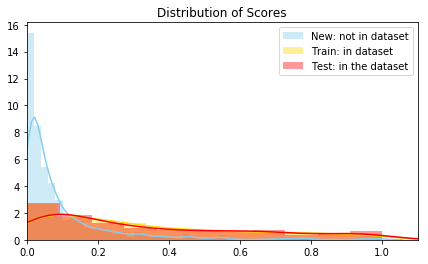

 42%|████▏     | 200006/473047 [1:38:08<71:11:16,  1.07it/s] 

('New score: ', 0.1407401)
('Train score: ', 0.36319092)
('Test score: ', 0.3134536)


 63%|██████▎   | 299999/473047 [2:25:30<1:23:32, 34.53it/s]  

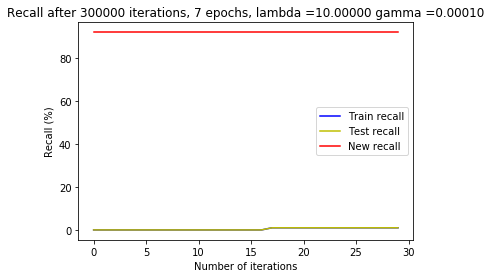

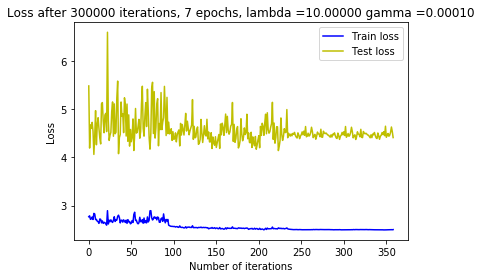

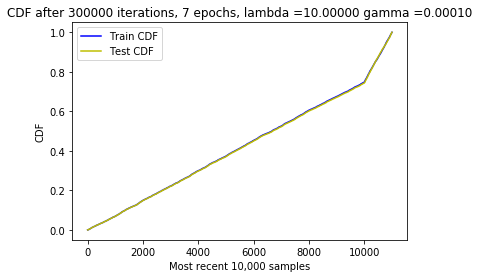

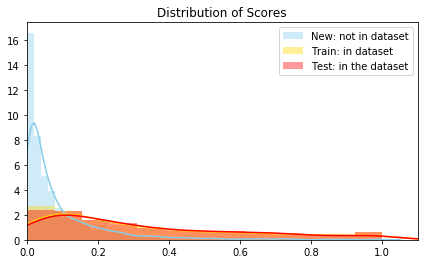

 63%|██████▎   | 300005/473047 [2:25:41<113:31:25,  2.36s/it]

('New score: ', 0.081194334)
('Train score: ', 0.3276435)
('Test score: ', 0.365924)


 85%|████████▍ | 399999/473047 [3:14:50<33:36, 36.23it/s]    

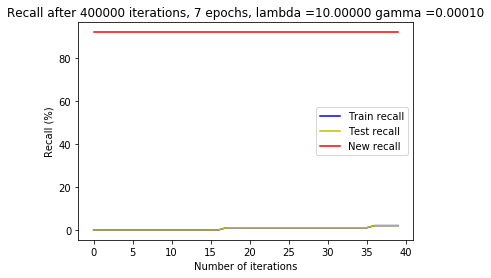

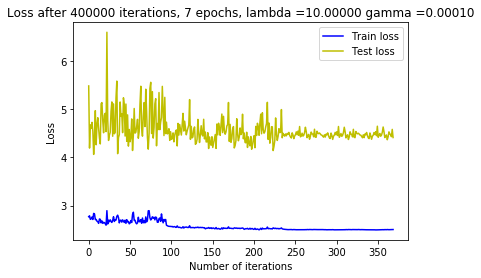

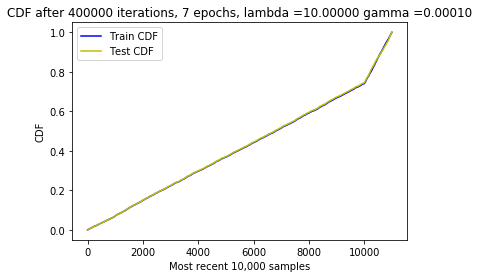

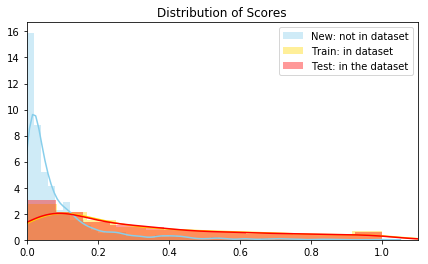

 85%|████████▍ | 400005/473047 [3:15:04<58:37:04,  2.89s/it]

('New score: ', 0.070285484)
('Train score: ', 0.32670638)
('Test score: ', 0.34077412)


100%|██████████| 473047/473047 [3:51:21<00:00, 34.08it/s]   


('Saving to: ', 'model_checkpoints/Conv1dModelSimple/04152020.pth')


 21%|██        | 99996/473047 [45:40<2:15:03, 46.04it/s]  

('Training Epoch: ', 8)


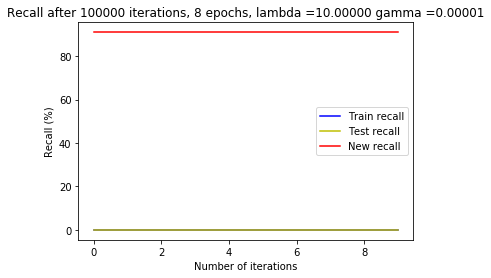

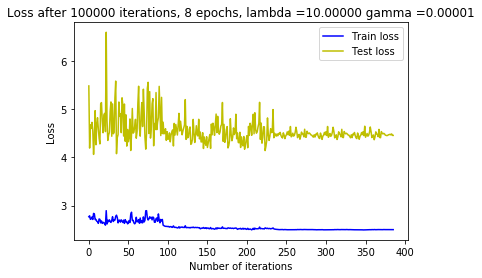

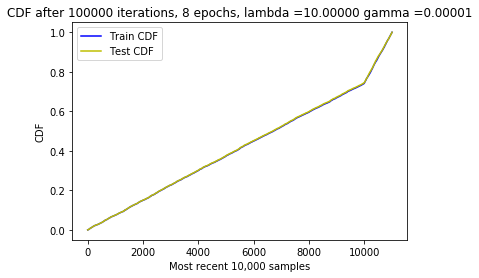

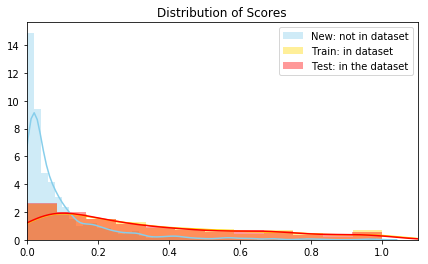

 21%|██        | 100006/473047 [45:47<97:24:52,  1.06it/s] 

('New score: ', 0.14364696)
('Train score: ', 0.3635322)
('Test score: ', 0.35878715)


 42%|████▏     | 199999/473047 [1:29:00<2:11:25, 34.63it/s]  

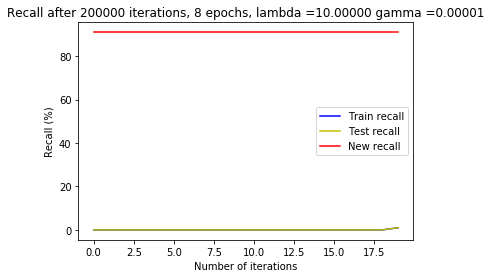

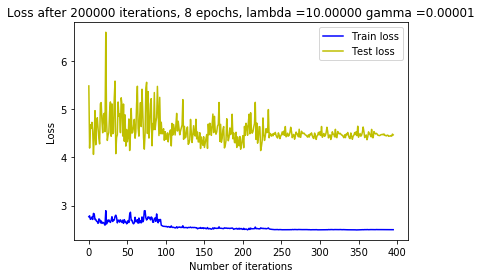

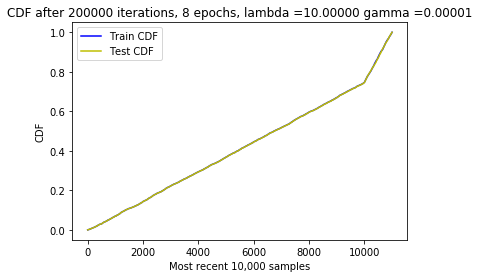

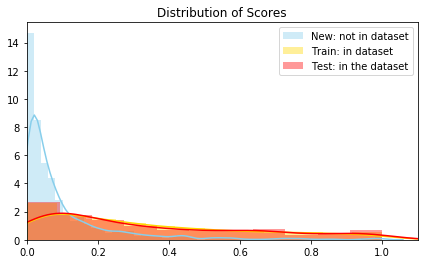

 42%|████▏     | 200005/473047 [1:29:06<176:39:34,  2.33s/it]

('New score: ', 0.14205797)
('Train score: ', 0.36266872)
('Test score: ', 0.3140263)


 63%|██████▎   | 299999/473047 [2:17:10<1:23:15, 34.64it/s]  

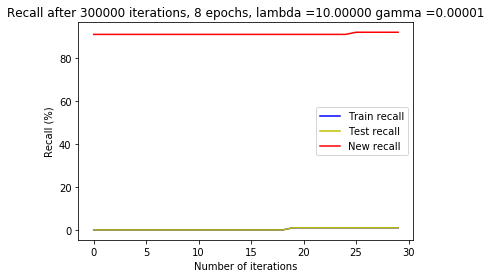

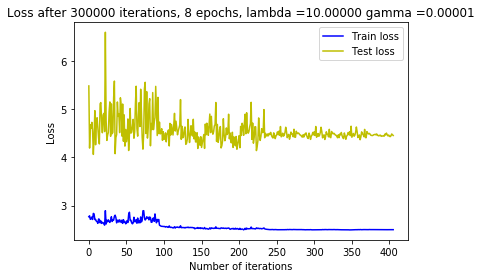

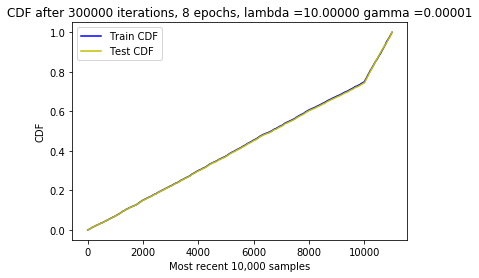

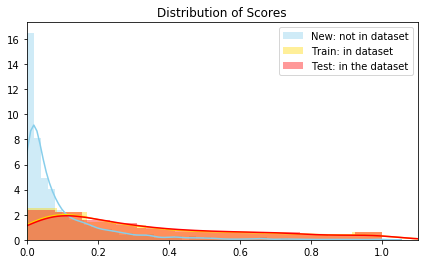

 63%|██████▎   | 300005/473047 [2:17:18<112:02:49,  2.33s/it]

('New score: ', 0.08315143)
('Train score: ', 0.33612624)
('Test score: ', 0.36940157)


 85%|████████▍ | 399999/473047 [3:04:10<35:35, 34.21it/s]    

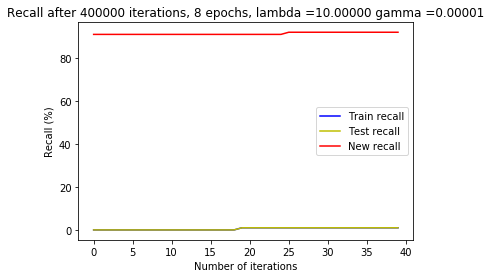

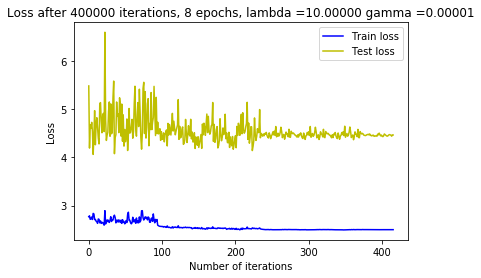

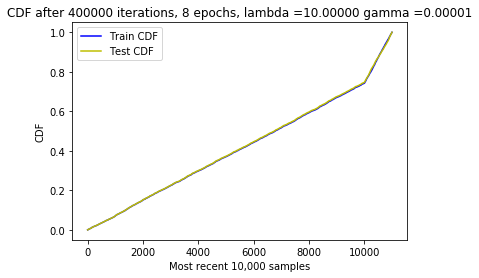

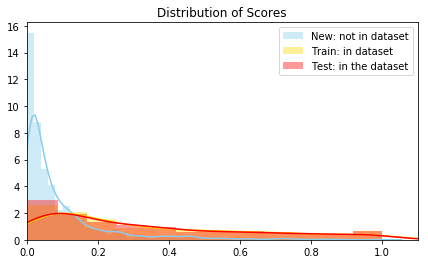

 85%|████████▍ | 400005/473047 [3:04:20<47:42:23,  2.35s/it]

('New score: ', 0.07381846)
('Train score: ', 0.33265156)
('Test score: ', 0.3480639)


100%|██████████| 473047/473047 [3:40:19<00:00, 35.78it/s]   


('Saving to: ', 'model_checkpoints/Conv1dModelSimple/04152020.pth')


 21%|██        | 99998/473047 [50:30<2:59:50, 34.57it/s]  

('Training Epoch: ', 9)


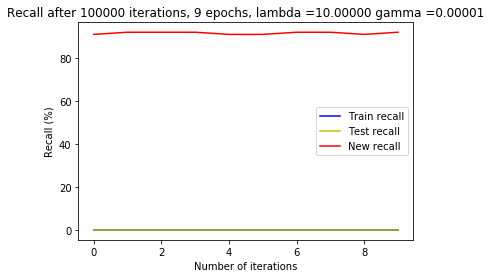

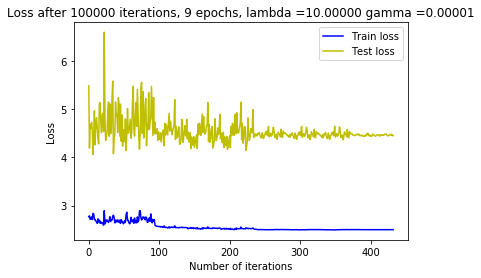

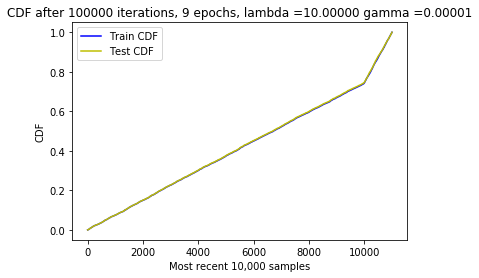

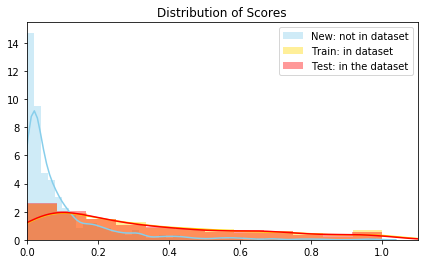

 21%|██        | 100005/473047 [50:33<162:24:04,  1.57s/it]

('New score: ', 0.1429262)
('Train score: ', 0.36286882)
('Test score: ', 0.35825175)


 42%|████▏     | 199998/473047 [1:37:30<2:10:35, 34.85it/s]  

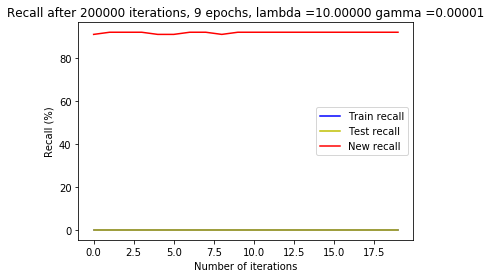

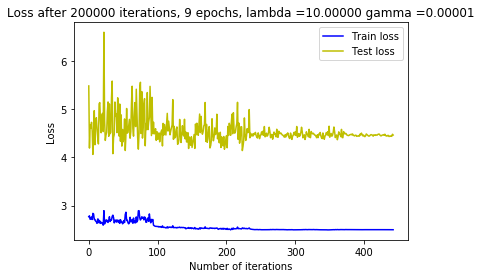

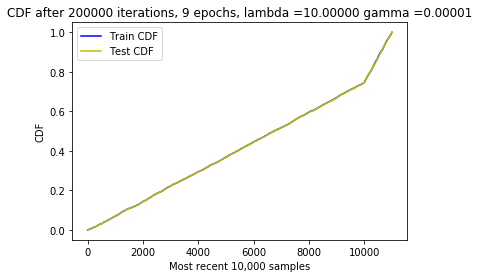

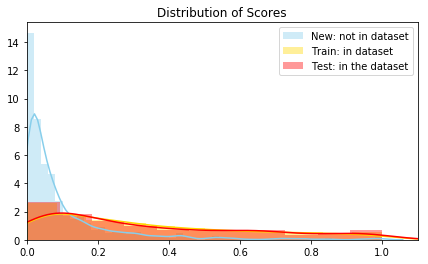

 42%|████▏     | 200006/473047 [1:37:40<119:04:59,  1.57s/it]

('New score: ', 0.14171132)
('Train score: ', 0.3622277)
('Test score: ', 0.31344935)


 63%|██████▎   | 299999/473047 [2:23:50<1:23:15, 34.64it/s]  

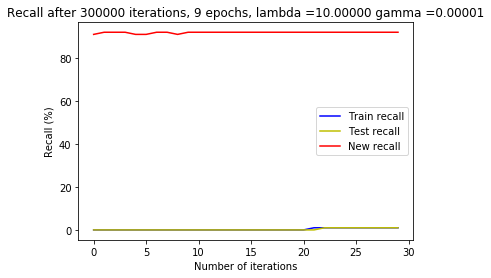

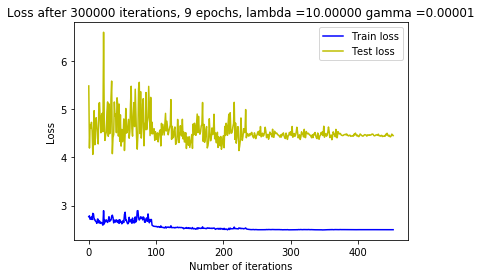

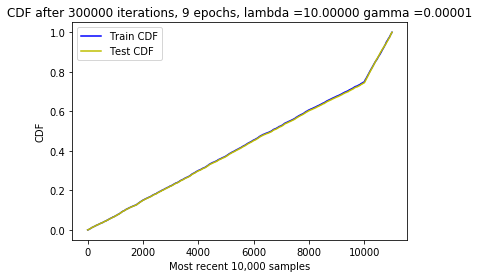

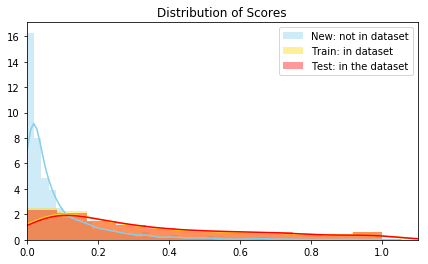

 63%|██████▎   | 300005/473047 [2:24:02<112:16:38,  2.34s/it]

('New score: ', 0.08337955)
('Train score: ', 0.33580413)
('Test score: ', 0.369366)


 85%|████████▍ | 399997/473047 [3:14:00<35:03, 34.73it/s]    

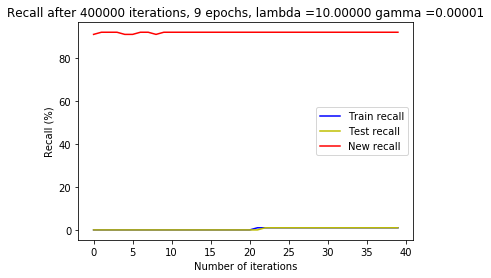

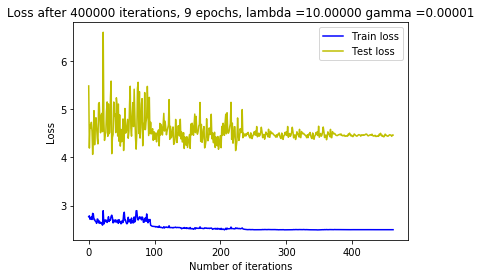

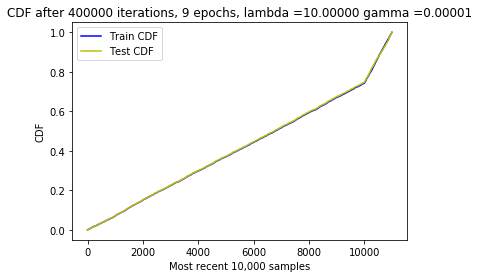

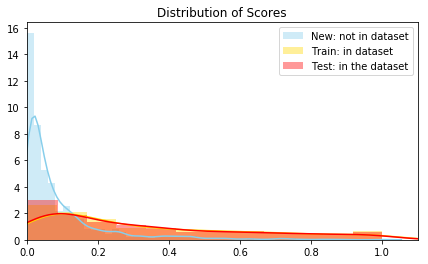

 85%|████████▍ | 400005/473047 [3:14:11<25:35:25,  1.26s/it]

('New score: ', 0.073702015)
('Train score: ', 0.332444)
('Test score: ', 0.34768268)


100%|██████████| 473047/473047 [3:50:29<00:00, 34.20it/s]   


('Saving to: ', 'model_checkpoints/Conv1dModelSimple/04152020.pth')


 21%|██        | 99998/473047 [48:30<2:28:43, 41.81it/s]  

('Training Epoch: ', 10)


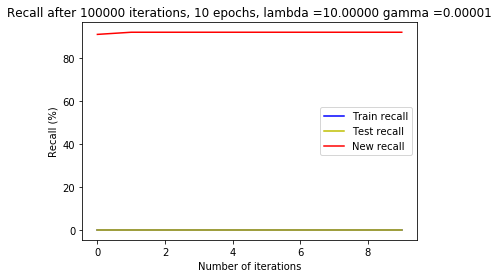

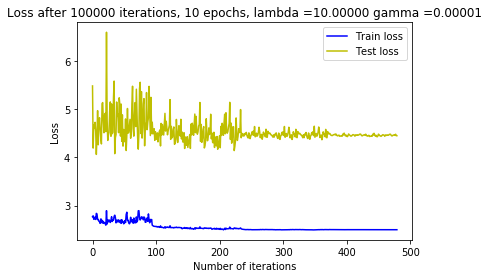

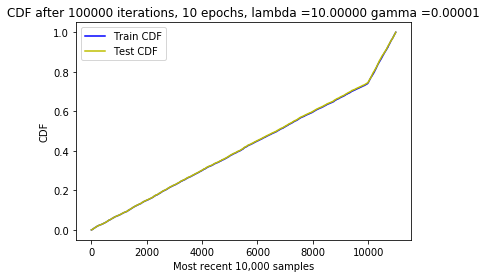

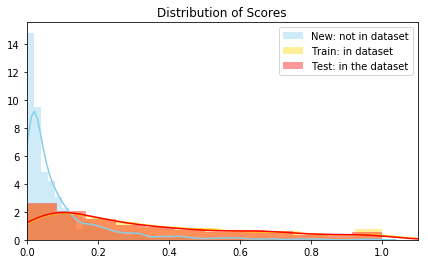

 21%|██        | 100005/473047 [48:41<160:15:45,  1.55s/it]

('New score: ', 0.1427762)
('Train score: ', 0.3625461)
('Test score: ', 0.35841835)


 42%|████▏     | 200000/473047 [1:30:50<2:10:57, 34.75it/s]  

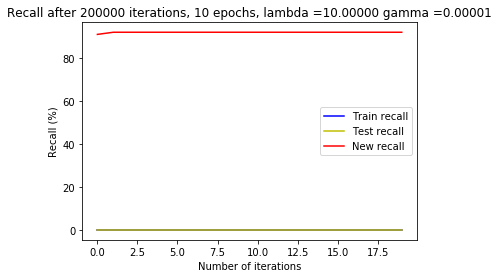

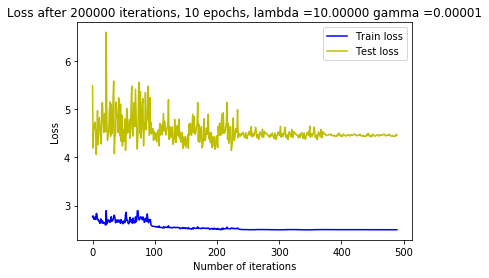

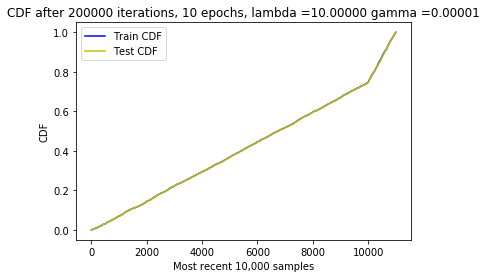

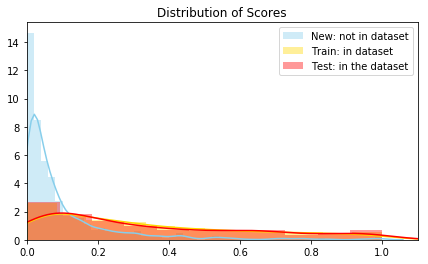

 42%|████▏     | 200005/473047 [1:30:52<349:09:28,  4.60s/it]

('New score: ', 0.14183325)
('Train score: ', 0.3622815)
('Test score: ', 0.31337982)


 63%|██████▎   | 299999/473047 [2:16:40<1:23:34, 34.51it/s]  

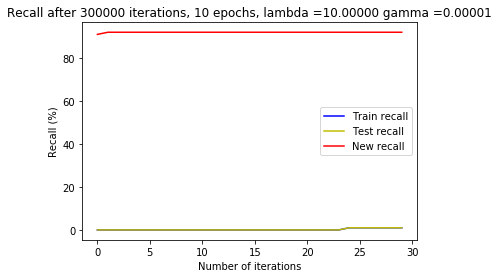

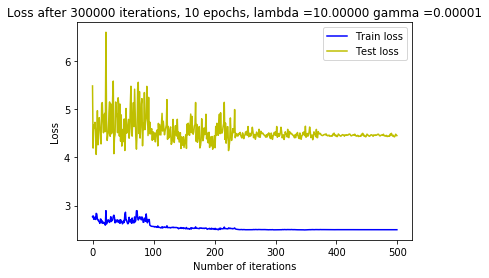

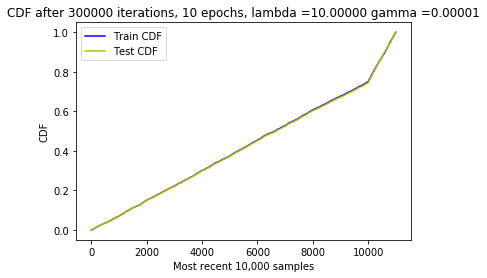

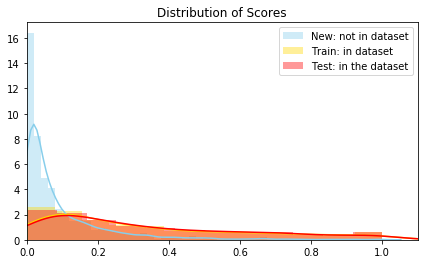

 63%|██████▎   | 300005/473047 [2:16:43<111:42:25,  2.32s/it]

('New score: ', 0.083466776)
('Train score: ', 0.33589068)
('Test score: ', 0.36949936)


 85%|████████▍ | 400000/473047 [3:04:40<35:32, 34.25it/s]    

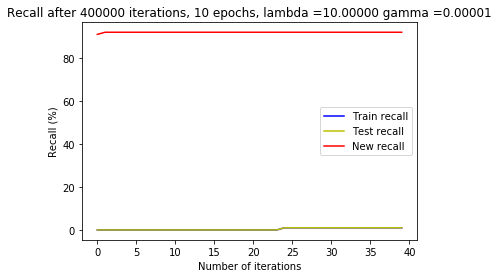

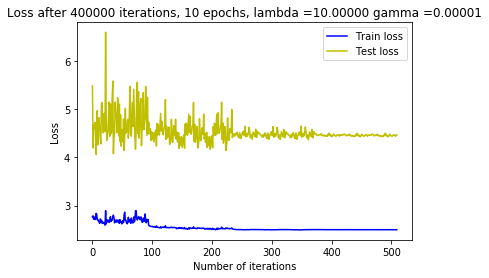

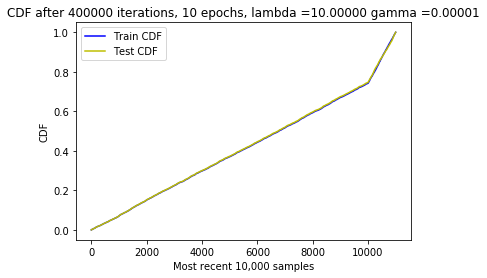

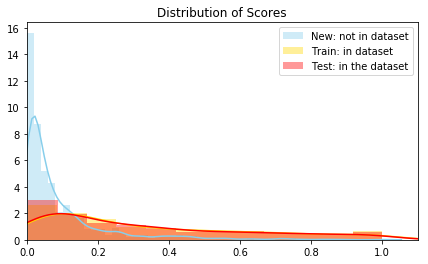

 85%|████████▍ | 400005/473047 [3:04:52<94:26:05,  4.65s/it] 

('New score: ', 0.073662065)
('Train score: ', 0.3325249)
('Test score: ', 0.3476493)


100%|██████████| 473047/473047 [3:40:58<00:00, 35.68it/s]    


('Saving to: ', 'model_checkpoints/Conv1dModelSimple/04152020.pth')


In [15]:
model = Conv1dModelSimple()
checkpoint = None
save_path = 'model_checkpoints/Conv1dModelSimple/04152020.pth'



sgd(epochs=EPOCHS, lamb=lamb, gamma=gamma, run_from_checkpoint=checkpoint, save_checkpoints=save_path)

## Relevance of learned motifs

In [16]:
# checkpointed_model = '../models/model_checkpoints/mle_model.pth'
# checkpoint = torch.load(checkpointed_model)
# model = Conv1dModelSimple()
# optim = SGD(model.parameters(), lr=1e-3)
# model.load_state_dict(checkpoint['model_state_dict'])
# optim.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# model.to(device)
# print(str(epoch))

In [17]:
# print(str(len(S_prime_test)))
# print(str(len(S_test)))

In [18]:
# Validation set is S_prime_test and S_test
# validation_set = []
# for (apt, pep), label in S_prime_test[:118262]:
#     validation_set.append((apt, pep, label))

# for (apt, pep) in S_test[:4000]:
#     validation_set.append((apt, pep, 0))

# np.random.shuffle(validation_set)

In [19]:
# validation_set[0]

In [20]:
# correct = 0
# hydrophobicity_binding = []
# hydrophobicity_free = []
# arginine_binding = []
# arginine_free = []

# for (apt, pep, label) in validation_set:
#     if 'Conv1' in model.name:
#         conv_type='1d'
#     else:
#         conv_type='2d'
#     x, y = convert(apt, pep, conv_type=conv_type)
#     score = model(x, y).cpu().detach().numpy().flatten()[0]
#     hp = 0
#     for aa in pep:
#         hp += hydrophobicity[aa]
    
#     if score < 0.3:
#         hydrophobicity_free.append(hp)
#         arginine_free.append(pep.count('R'))
#     elif score > 0.6:
#         hydrophobicity_binding.append(hp)
#         arginine_binding.append(pep.count('R'))


In [21]:
# print("Average Hydrophobicity of binding peptides: ", np.mean(np.asarray(hydrophobicity_binding)))
# print("Average Hydrophobicity of non-binding peptides: ", np.mean(np.asarray(hydrophobicity_free)))
# print("Average Number of Arginines in binding peptides: ", np.mean(np.asarray(arginine_binding)))
# print("Average Number of Arginines in non-binding peptides: ", np.mean(np.asarray(arginine_free)))

In [22]:
# plt.hist(hydrophobicity_binding, bins=10, label='Hydrophobicity of Binding Peptides')
# plt.hist(hydrophobicity_free, bins=10 , label='Hydrophobicity of Non-Binding Peptides')
# plt.ylabel("Density")
# plt.xlabel("Hydrophobicity Score")
# plt.title('Hydrophobicity of Test Set Outputs')
# plt.legend()
# plt.show()

In [23]:
# Arginine content
# plt.hist(arginine_binding, bins=8, label='Number of arginines in binding peptides')
# plt.hist(arginine_free, bins=8 , label='Number of arginines in non-binding peptides')
# plt.ylabel("Density")
# plt.xlabel("Number of Arginines")
# plt.title('Arginine Count in Peptides')
# plt.legend()
# plt.show()